In [2]:
## 라이브러리 참조

from hossam import load_data
from pandas import DataFrame, melt, get_dummies
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

from math import sqrt
from scipy.stats import (
    skew,
    kurtosis,
    t,
    mannwhitneyu,
    pearsonr,
    spearmanr,
    probplot,
    ttest_ind,
    normaltest,
    bartlett,
    levene,
    wilcoxon,
)
import jenkspy

from sklearn.preprocessing import MinMaxScaler

from statannotations.Annotator import Annotator
from statsmodels.stats.diagnostic import linear_reset
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pingouin import welch_anova, pairwise_gameshowell

from itertools import combinations

In [3]:
## 그래프 초기화
my_dpi = 200
font_path = "../../etc/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name
plt.rcParams["font.size"] = 10
plt.rcParams["axes.unicode_minus"] = False

In [4]:
## Data load

origin = load_data("insurance")

print("\n===데이터 크기 확인===")
print(f"데이터셋 크기:{origin.shape}")
print(f"열 개수:{origin.shape[1]}")
print(f"행 개수:{origin.shape[0]}")

print("\n===타입 확인===")
display(origin.info())

print("\n===상위 5행===")
display(origin.head())

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.


===데이터 크기 확인===
데이터셋 크기:(1338, 7)
열 개수:7
행 개수:1338

===타입 확인===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smok

None


===상위 5행===


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
## 미션1-1 데이터 점검, 처리기준 제시

print("== 결측 및 중복 확인 ==")
display(origin.isna().sum())

fields = ["age", "bmi", "children", "charges"]

data = origin[fields]


# 편향성 확인
def outlier_skew(data):
    results = {}
    for col in data.columns:
        temp = data[col].dropna()
        # 왜도 계산
        skew_original = temp.skew()
        k_original = temp.kurtosis()

        # 이상치 직접 계산
        Q3 = temp.quantile(0.75)
        Q1 = temp.quantile(0.25)
        IQR = Q3 - Q1
        outline_max = Q3 + IQR * 1.5
        outline_min = Q1 - IQR * 1.5
        ouline_max_count = (temp > outline_max).sum()
        ouline_min_count = (temp < outline_min).sum()

        # 로그 변환 필요 여부
        dataset_log = np.log1p(temp - temp.min() + 1)
        skew_log = dataset_log.skew()
        # 로그 변환 필요 여부 판단
        need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

        # 정리
        results[col] = {
            "skew": skew_original,
            "kuritosis": k_original,
            "상향 이상치 개수": ouline_max_count,
            "하향 이상치 개수": ouline_min_count,
            "로그변환필요여부": need_log,
        }
    skew_outlier_df = DataFrame(results).T
    return skew_outlier_df


print("\n== 편향성 확인 ==")
display(DataFrame(outlier_skew(data)))


# 미션1-2 변수 범위, 현실성 판단
print("== 기초통계량 ==")
display(data.describe().T)

== 결측 및 중복 확인 ==


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


== 편향성 확인 ==


,skew,kuritosis,상향 이상치 개수,하향 이상치 개수,로그변환필요여부
age,0.055673,-1.245088,0,0,False
bmi,0.284047,-0.050732,9,0,False
children,0.93838,0.202454,0,0,False
charges,1.51588,1.606299,139,0,True


== 기초통계량 ==


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


범주형 변수 비율:  sex
male      50.523169
female    49.476831
Name: proportion, dtype: float64 

범주형 변수 비율:  smoker
no     79.521674
yes    20.478326
Name: proportion, dtype: float64 

범주형 변수 비율:  region
southeast    27.204783
southwest    24.289985
northwest    24.289985
northeast    24.215247
Name: proportion, dtype: float64 



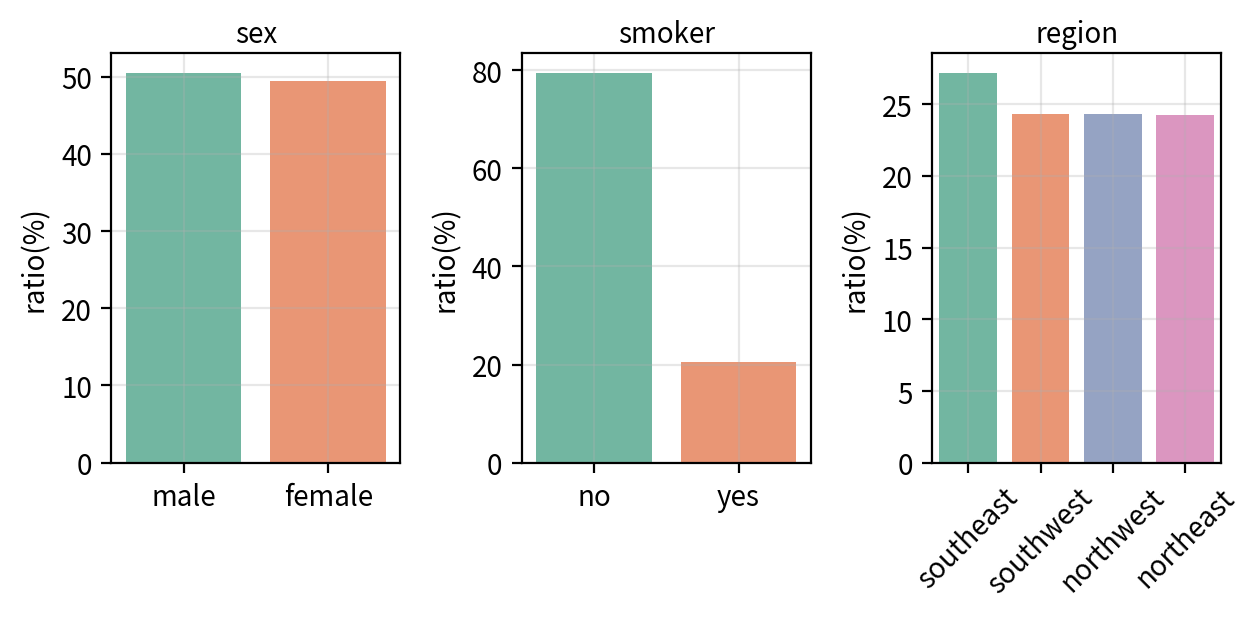

In [6]:
# 미션1-3 범주형 변수 구성 및 비율 확인
fields1 = ["sex", "smoker", "region"]

width_px = 1280
height_px = 640
rows = 1
cols = 3

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(fields1):
    ratio = origin[v].value_counts(normalize=True) * 100
    print("범주형 변수 비율: ", ratio, "\n")
    sb.barplot(x=ratio.index, y=ratio.values, hue=ratio.index, ax=ax[i], palette="Set2")
    ax[i].grid(True, alpha=0.3)
    ax[i].xaxis.set_label_position("top")
    ax[i].set_ylabel("ratio(%)")

ax[2].tick_params(axis="x", rotation=45)

# 4. 출력
plt.tight_layout()
plt.show()
plt.close()

#### 미션1. 데이터 신뢰성 평가
1. 결측·이상치·편향을 점검하고, 처리 기준을 제시한다.
    - 데이터 확인결과 결측치 없이 완전한 데이터를 보인다.
    - age, bmi에서는 우편향 판정으로 보이나 age의 경우 평균은 39.2, 중앙값은 39이며, bmi의 경우 평균은 30.6, 중앙값은 30.4로 확인되어 편향성이 미미하다.
    - charges의 경우 평균 13270.4, 중앙값 9382.0으로 왜도와 첨도가 1.5 이상으로 우편향을 보이며 오른쪽 꼬리가 길어 정규분포를 따르지 않고, 이상치가 다수 확인되므로 로그등을 활용한 정규화 과정이 필요하다.
2. charges가 음수이거나 극단값인지, age/bmi 등의 범위가 현실적인지 확인한다.
    - 데이터의 기초통계량을 보면 charges의 min값은 0 이상으로 음수인 부분은 없다.
    - age와 bmi의 범위는 현실적으로 확인된다.
    - bmi의 수치가 15.96, 53.13의 경우는 심각한 체중 이상 상태로 다양한 건강문제에 직면한 사람일 수 있다.
3. 범주형 변수(sex, smoker, region)가 몇 개의 범주로 구성되어 있고, 특정 범주에 데이터가 지나치게 몰려 있지는 않은지 확인한다.
    - 범주형 변수는 막대그래프를 사용하여 범주 구성과 비율의 시각화를 수행하였다.
    - sex와 smoker는 각 2종, region은 4종으로 확인되고, smoker의 경우 no에 약 79%로 확인된다.
4. 전처리 전·후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약을 만든다.
    - charges는 많은 이상치가 보이고, 정규분포를 따르지 않으므로 log함수를 이용하여 이상치를 정제하고 정규분포를 따르도록 진행한다.
5. 단위·해석 주의: charges는 USD입니다. 현실적인 의료비 수준인지 평가하세요.
    - 2019년기준 미국 1인당 의료비 지출은 약 1292만으로 GDP의 약 17%가 의료비에 사용되며, OECD평균 8.8%에 비해 약 2배 높은 수준으로 확인된다.
    

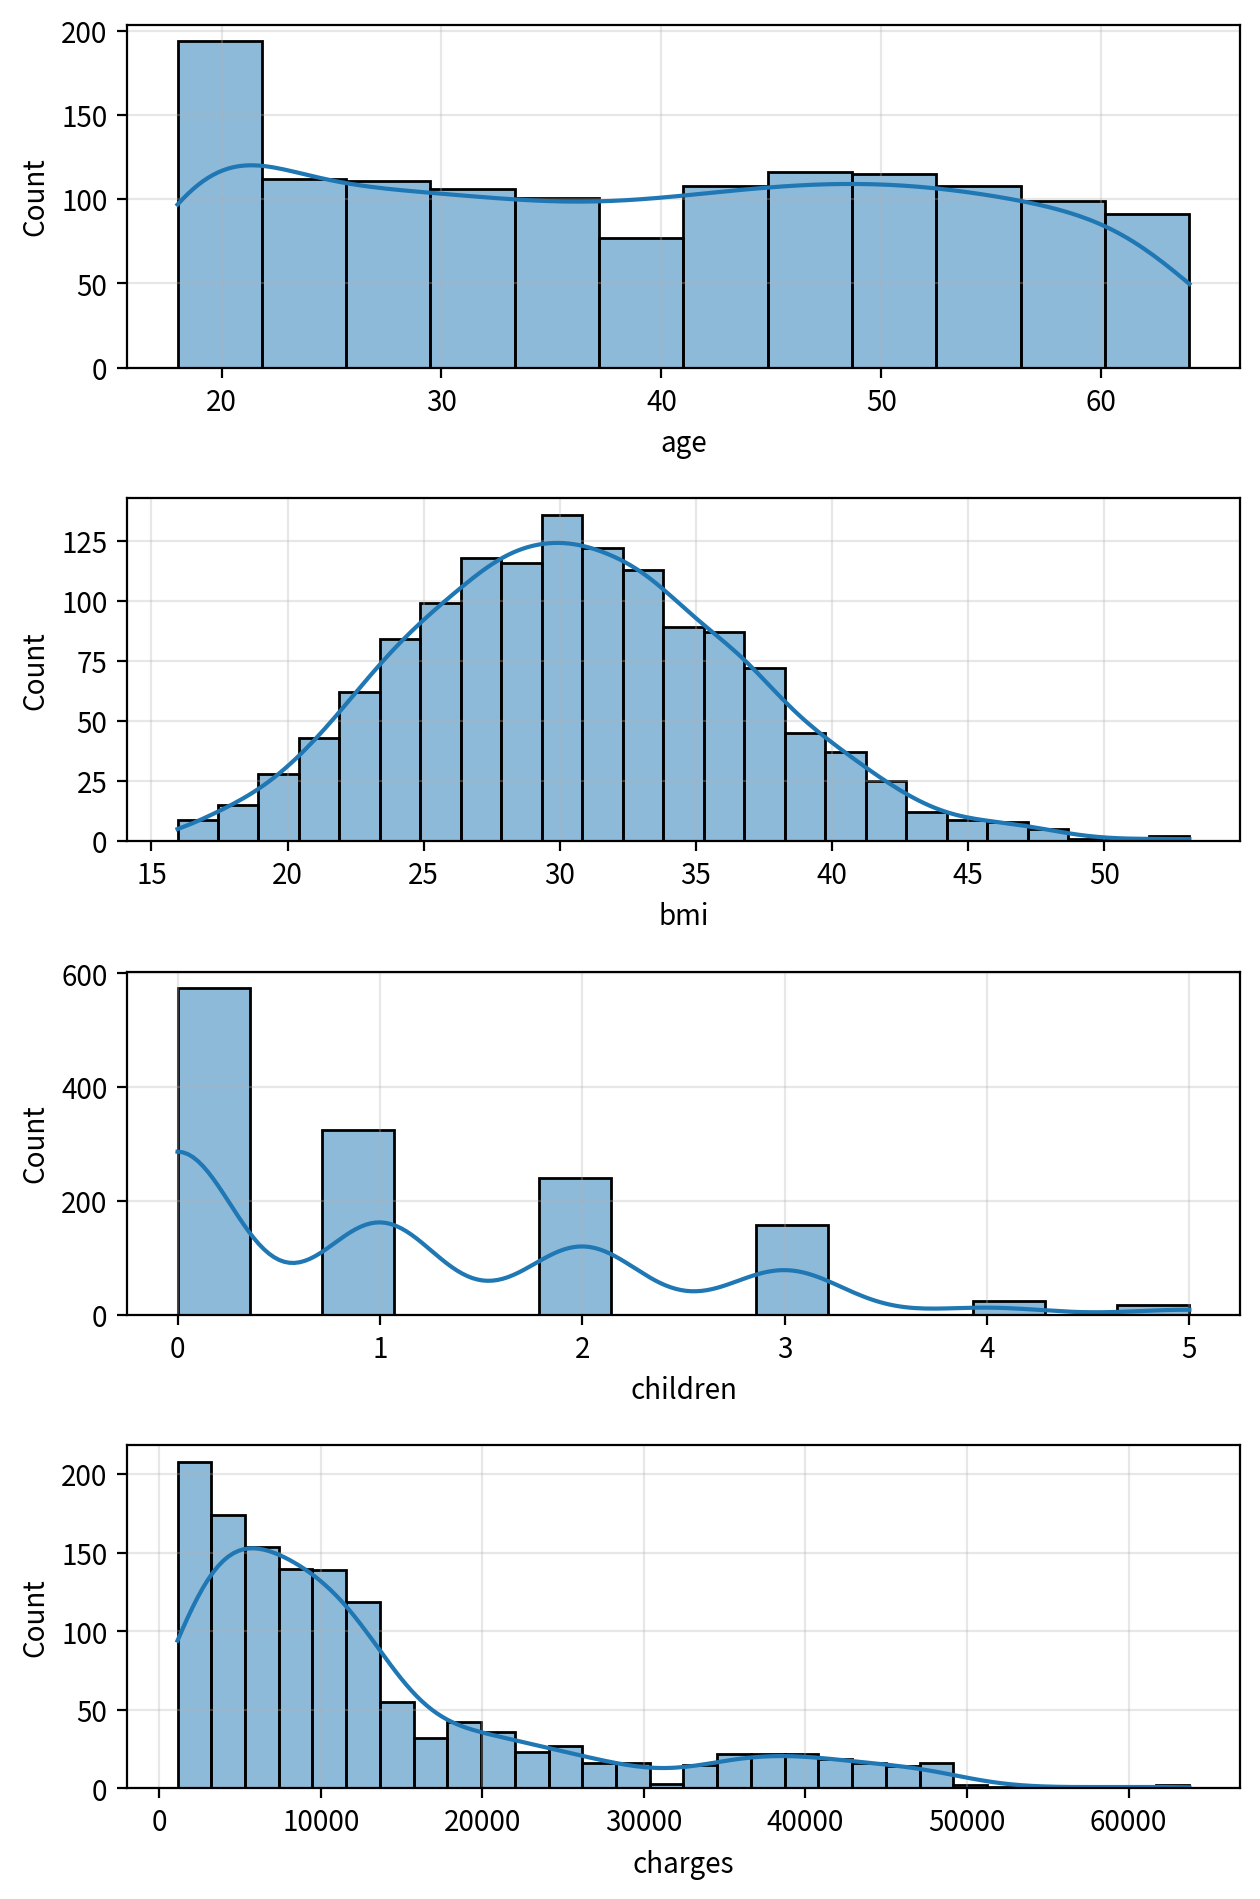

In [7]:
# 미션2-1 변수별 Histo/KDE 그래프 확인
fields2 = ["age", "bmi", "children", "charges"]
data = origin[fields2]

width_px = 640 * 2
height_px = 480 * 4
rows = len(fields2)
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, c in enumerate(data.columns):
    sb.histplot(data=data[c], alpha=0.5, kde=True, ax=ax[i])
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

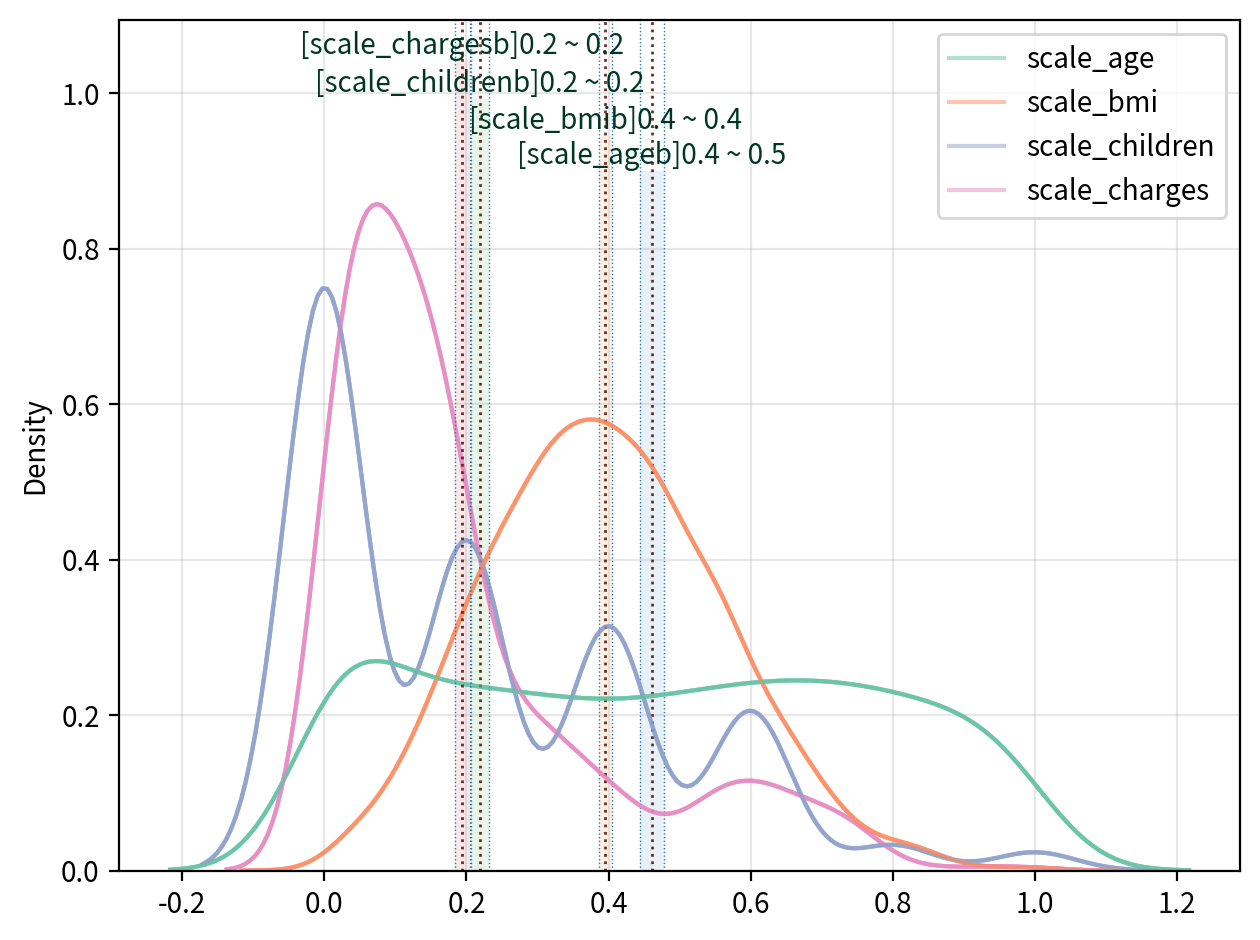

In [8]:
# 미션2-3
scaler = MinMaxScaler()
scale_fields2 = [
    "scale_age",
    "scale_bmi",
    "scale_children",
    "scale_charges",
]

df1 = origin.filter(fields2)
for i, v in enumerate(fields2):
    df1["scale_" + v] = scaler.fit_transform(origin[[v]])
    df1 = df1.drop([v], axis=1)

data = df1

width_px = 640 * 2
height_px = 480 * 2
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    sb.kdeplot(data=data, fill=False, alpha=0.5, palette="Set2")

    max = data[c].max()
    clevel = 0.95
    dof = len(data[c]) - 1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=":", linewidth=0.5)
    ax.axvline(cmax, linestyle=":", linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    ax.axvline(sp_mean, linestyle=":", linewidth=1, color="#6e2b20")

    ax.text(
        x=(cmax - cmin) / 2 + cmin,
        y=ymax,
        s="[%sb]%0.1f ~ %0.1f" % (c, cmin, cmax),
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 10, "color": "#003724"},
    )

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

#### 미션2. 핵심 변수 탐색
1. charges, age, bmi, children 분포를 히스토그램/KDE로 확인하고 알 수 있는 객관적 사실을 서술한다.
   
    |변수|분포형태|특징|범위|
    |---|---|---|---|
    |Age|전체적으로 균등한 분포를 보임|전 연령에 걸쳐 인원이 고르게 분포되어 있음|18~65세 사이의 범위를 가짐|
    |BMI|정규 분포와 유사하나 우편향 형태를 보임|최빈값이 30 근처에서 많이보이며, 비만기준에 해당하는 사람이 많음을 의미하고, 15, 50에 근접한 인원도 존재함|15~50 사이의 범위를 가짐|
    |Children|심한 우편향을 보임|대부분 자녀가 없으며, 자녀 수가 증가할수록 급격한 감소형태를 보임|0명에서 5명 사이의 범위를 가짐|
    |Charges|심한 우편향을 보임|대다수의 보험청구액이 낮은 금액에 모여있으며, 금액이 높아질수록 빈도가 줄어듬|1121 USD에서 63770 USD의 범위를 가짐|
<p>

2. 왜도/이상치가 회귀에 줄 수 있는 영향과 변환할 필요가 있는지 서술하시오.
    1) 왜도는 데이터 분포의 비대칭성을 유발하여 모델가정위반, 계수추정위반, 예측성능저하, 추정신뢰구간 왜곡을 유발함
    2) 이상치는 회귀선을 왜곡하고, 모델적합도($R^2$)와 MSE를 증가하여 모델 성능을 저하함으로서 잘못된 결론을 내리게 함
    3) 그러므로 데이터 분석단계에서 로그변환 등을 통하여 왜도를 줄이거나 이상치를 식별 및 처리하여 회귀모델의 정확성과 신뢰성을 높이는데 필수적임

3. 분포 비교는 동일 축 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약하세요.
    
    |변수|분포 형태|평균/중앙값 차이|꼬리 특성|
    |---|---|---|---|
    |age|비교적 대칭적인 정규 분포 형태|평균과 중앙값이 유사할 것으로 예상|꼬리가 길지 않고 비교적 |대칭적
    |bmi|비교적 대칭적인 정규 분포 형태|평균과 중앙값이 유사할 것으로 예상|꼬리가 길지 않고 비교적 |대칭적
    |children|오른쪽으로 치우친(우편향) 분포|평균이 중앙값보다 클 것으로 예상|오른쪽에 긴 꼬리가 |형성됨
    |charges|오른쪽으로 매우 치우친(강한 우편향) 분포|평균이 중앙값보다 훨씬 클 것으로 예상	|오른쪽에 매우 길고 두꺼운 꼬리가 형성됨
<p>

4. 의료비의 long-tail 분포(극단적 고액 청구)가 해석에 미치는 영향도 짧게 언급하세요. 
    -  소수의 극단적으로 높은 비용청구는 전체 평균비용의 대부분을 차지하게 되어 평균이 중앙값보다 훨씬 커지게 되어 평균적인 환자의 의료비보다 전체 의료 시스템에서 발생하는 총 비용의 평균을 나타냄
    - 선형 회귀와 같은 정규분포를 가정하는 통계 방식에서 비대칭성과 이분산성 문제가 발생함

In [9]:
# 미션3-1 로그/제곱근 적용 전후 비교
sqrt_fields2 = [
    "sqrt_age",
    "sqrt_bmi",
    "sqrt_children",
    "sqrt_charges",
]

log_fields2 = [
    "log_age",
    "log_bmi",
    "log_children",
    "log_charges",
]


df2 = origin.filter(fields2)
for i, v in enumerate(fields2):
    df2["log_" + v] = np.log1p(origin[v])
    df2 = df2.drop([v], axis=1)

df3 = origin.filter(fields2)
for i, v in enumerate(fields2):
    df3["sqrt_" + v] = np.sqrt(origin[v])
    df3 = df3.drop([v], axis=1)

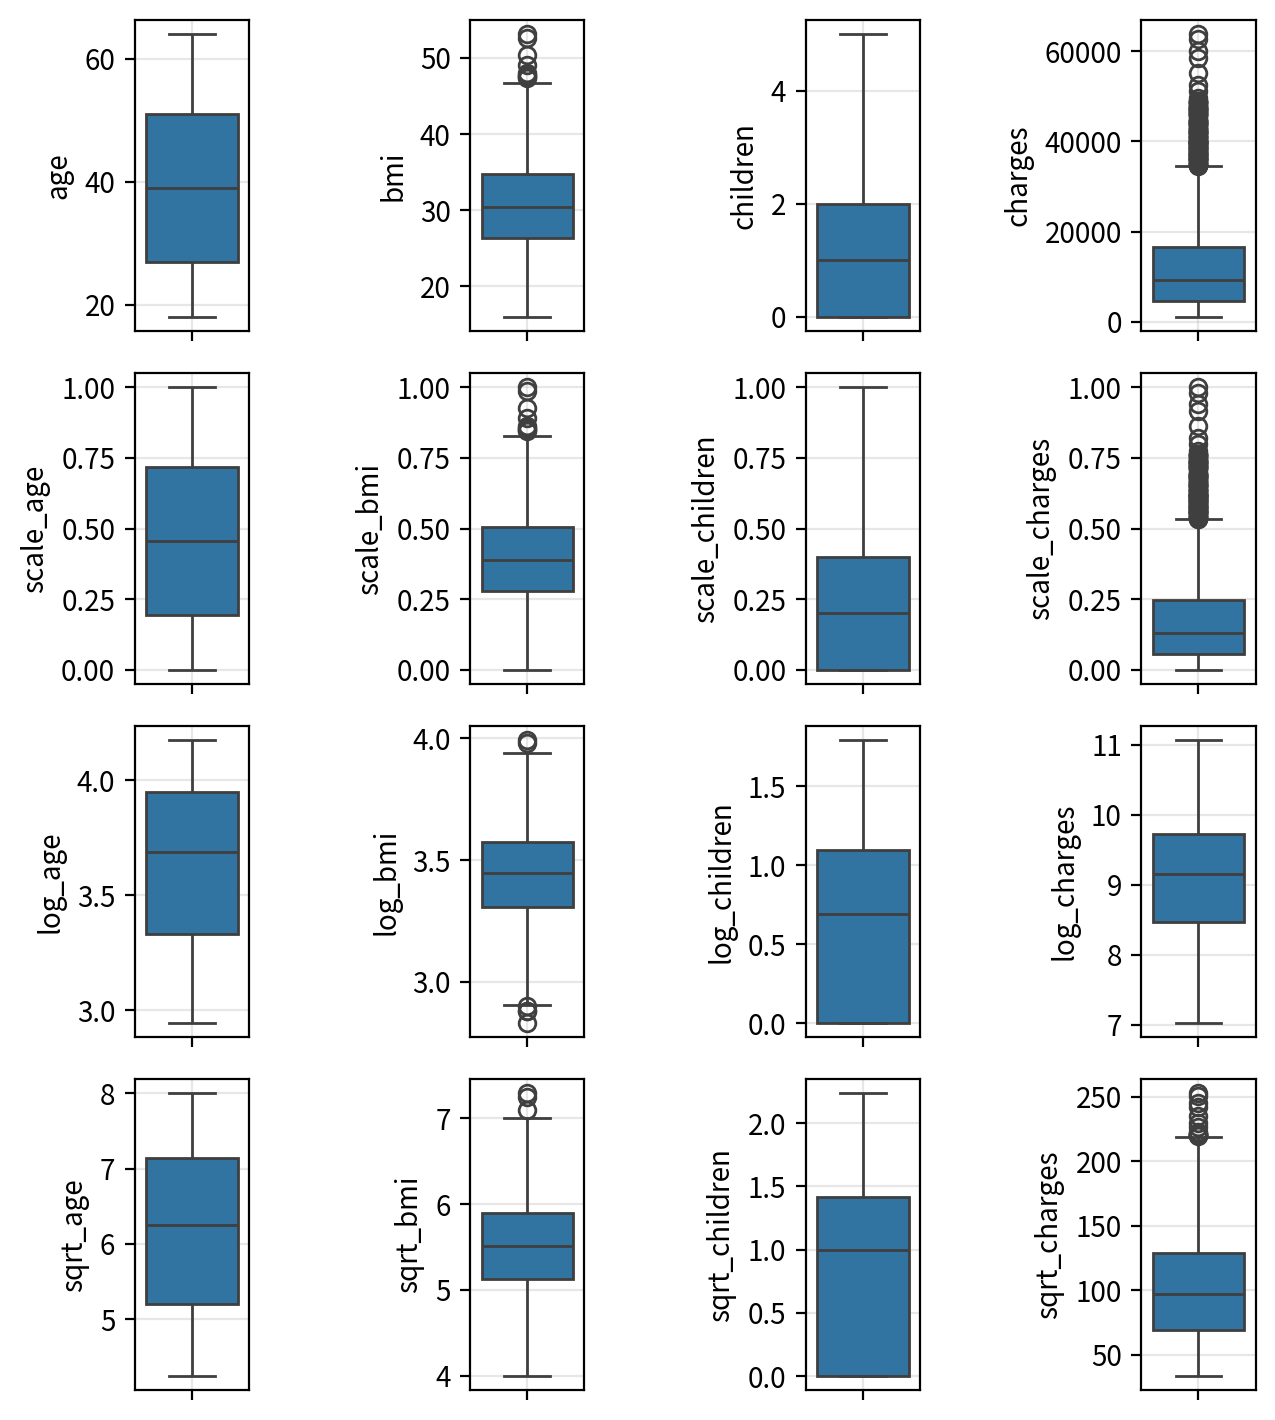

,skew,kuritosis,상향 이상치 개수,하향 이상치 개수,로그변환필요여부
age,0.055673,-1.245088,0,0,False
bmi,0.284047,-0.050732,9,0,False
children,0.93838,0.202454,0,0,False
charges,1.51588,1.606299,139,0,True


,skew,kuritosis,상향 이상치 개수,하향 이상치 개수,로그변환필요여부
scale_age,0.055673,-1.245088,0,0,False
scale_bmi,0.284047,-0.050732,9,0,False
scale_children,0.93838,0.202454,0,0,False
scale_charges,1.51588,1.606299,139,0,True


,skew,kuritosis,상향 이상치 개수,하향 이상치 개수,로그변환필요여부
log_age,-0.361068,-1.126953,0,0,False
log_bmi,-0.23824,-0.150027,2,4,False
log_children,0.264083,-1.343101,0,0,False
log_charges,-0.089817,-0.636855,0,0,False


,skew,kuritosis,상향 이상치 개수,하향 이상치 개수,로그변환필요여부
sqrt_age,-0.15666,-1.23033,0,0,False
sqrt_bmi,0.014147,-0.20723,3,0,False
sqrt_children,0.11635,-1.492507,0,0,False
sqrt_charges,0.795863,-0.073061,16,0,False


In [10]:
# 미션3-1 로그/제곱근 적용 전후 비교
width_px = 640 * 2
height_px = 480 * 3
rows = 4
cols = 4

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(fields2):
    sb.boxplot(data=origin[v], ax=ax[0][i])
    ax[0][i].grid(True, alpha=0.3)

for i, v in enumerate(scale_fields2):
    sb.boxplot(data=df1[v], ax=ax[1][i])
    ax[1][i].grid(True, alpha=0.3)

for i, v in enumerate(log_fields2):
    sb.boxplot(data=df2[v], ax=ax[2][i])
    ax[2][i].grid(True, alpha=0.3)

for i, v in enumerate(sqrt_fields2):
    sb.boxplot(data=df3[v], ax=ax[3][i])
    ax[3][i].grid(True, alpha=0.3)

plt.tight_layout(w_pad=3)
plt.show()
plt.close()

df_set = [origin[fields2], df1, df2, df3]
for i in df_set:
    display(outlier_skew(i))

#### 미션3. 로그 / 비선형 변환
1. charges 혹은 주요 변수(age, bmi, children)에 로그/제곱근 등 변환을 적용해 전후 분포를 나란히 비교한다.
    - 각 변수들에 대하여 변환전, Min-Max scale, Log, 제곱근 변환을 수행하여 boxplot형태로 표현하고, 왜도와 첨도 계산을 진행함

2. 변환이 해석과 모델 적합에 주는 장단점, 해석이 어떻게 달라지는지 예상한다.
    1) Min-Max 스케일링의 경우 charges의 상향 극단값이 전체 스케일을 결정하므로 다른 데이터들은 0에 가까운 범위에 몰려 해석이 어려워짐
    2)  Log 변환의 경우 왜도와 첨도가 0에 가까워짐으로써 정규분포에 가까운 형태를 보임. 따라서 선형 회귀모델의 가정을 충족하기 쉬워짐
    3) 제곱근 변환의 경우 로그변환과 유사하지만 변환의 효과가 log보다 약함. 그러나 0 값을 포함할 수 있기 때문에 children 변수 대응에 유리함

3. “이 변환이 없으면 어떤 함정에 빠질까?”를 한 줄로 정리한다.
    - 데이터 변환이 없으면 모델은 극단값에 과도하게 영향을 받아 편향될 수 있고, 특히 선형 모델의 경우 성능 저하와 잘못된 예측 결과를 초래함

4. 선택 기준을 명시하세요: 왜 log(charges)인지, 왜 특정 변수에 변환을 적용하는지 데이터 분포 근거로 설명합니다.
    - log_charges와 charges의 boxplot을 비교해보면 log_charges 그래프가 중앙값에 훨씬 고르게 분포하고, 대칭성을 이루는 것을 확인할 수 있음
    - age와 bmi의 경우 원본 분포 자체가 비교적 대칭적이기 때문에 로그 / 제곱근 변환을 하더라도 개선의 효과가 미미함
    - children 변수는 로그변환시 Log(0) 문제가 발생하기 때문에 log(children + 1)을 사용하는 것을 고려할 수 있음


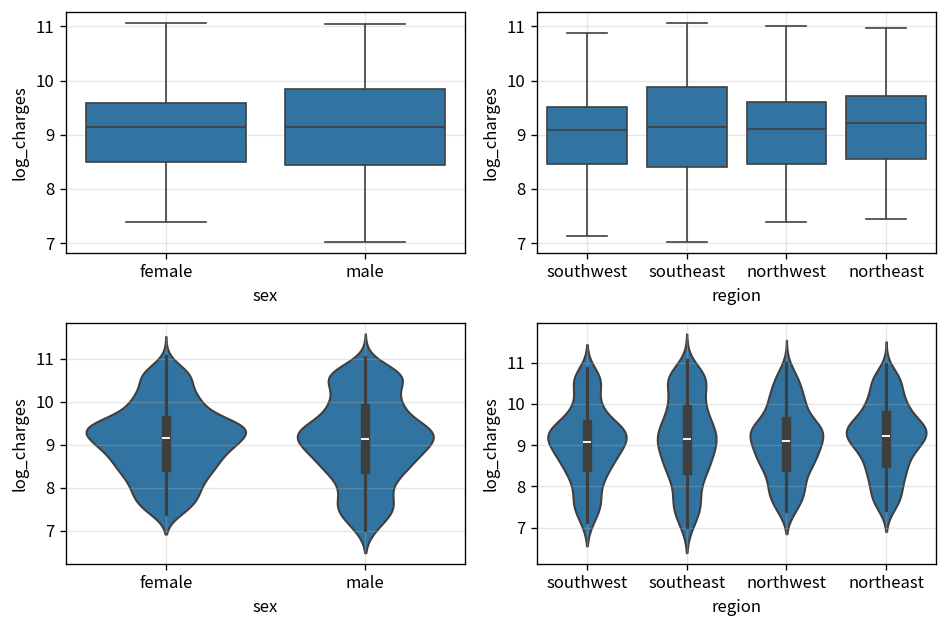

In [11]:
# 미션4
df4 = df2.copy()
fields3 = ["sex", "region"]
for f in fields3:
    df4[f] = origin[f]

data = df4
y = "log_charges"

my_dpi = 120
width_px = 960
height_px = 640
rows = 2
cols = 2

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i in range(2):
    for j, v in enumerate(fields3):
        if i == 0:
            sb.boxplot(data=data, x=v, y=y, ax=ax[i][j])
        else:
            sb.violinplot(data=data, x=v, y=y, ax=ax[i][j])
        ax[i][j].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

#### 미션4. 성별, 거주지역의 의료비의 관계
1. 성별(sex)과 지역(region)별 의료비 분포를 시각화(박스플롯, 바이올린 플롯)한다.

2. 중앙값·분포 겹침을 근거로 “어느 집단이 비싼가?”, “차이가 얼마나 뚜렷한가?”를 문장으로 적으세요.
    1) 성별에서 남성의 중앙값이 여성보다 약간 높지만, 전체적으로는 Y축 범위내에서 거의 완벽하게 겹침
    2) 거주지역에서는 동남, 동북부가 남서, 북서부 지역보다 높은 위치에 있지만, 모든 지역의 분포가 겹치므로 성별이나 지역 모두 보험료의 차이는 명확하게 구분할 수 없음

3. “왜 이런 차이가 생겼을까?”를 건강보험 체계·지역 의료 인프라·생활 비용 차이 등으로 추정해 보세요.
    
    1. 지역별 의료 인프라 및 공급자 가격 차이
        - 의료 서비스 가격 변동: 미국에서는 동일한 의료 서비스나 시술이라도 지역에 따라 보험사가 병원에 지불하는 금액이 크게 다릅니다. 특정 지역의 병원이나 의료 시스템이 더 높은 가격을 책정하거나 시장 지배력이 강할 경우, 해당 지역의 보험료가 높아질 수 있습니다.
        - 의료 자원의 종류 및 활용 패턴: 지역별로 의료 자원(병원, 전문의 수 등)의 수와 유형이 다르며, 의료진의 진료 방식이나 패턴도 다릅니다. 예를 들어, 특정 지역에서는 외래 진료보다 입원 치료를 더 선호하는 경향이 있어 비용 증가로 이어질 수 있습니다.
        - 주요 교육 병원 유무: 대규모 교육 병원(teaching hospitals)이 있는 지역은 종종 더 높은 의료비를 발생시킬 수 있으며, 이는 해당 지역의 평균 보험료에 영향을 줍니다. 
    2. 건강보험 체계 및 시장 경쟁 정도
        - 보험사 간 경쟁 수준: 보험 회사가 적어 경쟁이 부족한 지역(특히 시골 지역)은 경쟁이 치열한 도시 지역보다 보험료가 더 높게 책정될 수 있습니다.
        - 주(State) 규정 및 요구사항: 각 주는 연방 정부의 ACA(건강보험개혁법) 최소 요건 외에 추가적인 보장 범위를 요구할 수 있으며, 이는 주별 보험료 차이로 나타납니다.
        - 위험 풀(Risk Pools)의 크기: 특정 지역의 보험 가입자 수가 적으면 위험 풀이 작아져, 소수의 고액 청구가 전체 평균 보험료에 더 큰 영향을 미칠 수 있습니다. 
    3. 생활 비용 및 인구 통계학적 차이
        - 생활 비용(Cost of Living): 의료진의 인건비, 병원 운영비 등 전반적인 지역 생활 비용이 높은 지역일수록 의료 서비스 가격과 보험료가 높아지는 경향이 있습니다.
        - 인구의 건강 상태 및 선호도: 지역 주민들의 평균적인 건강 상태나 의료 서비스 이용에 대한 선호도 차이도 보험료에 영향을 줄 수 있습니다.    


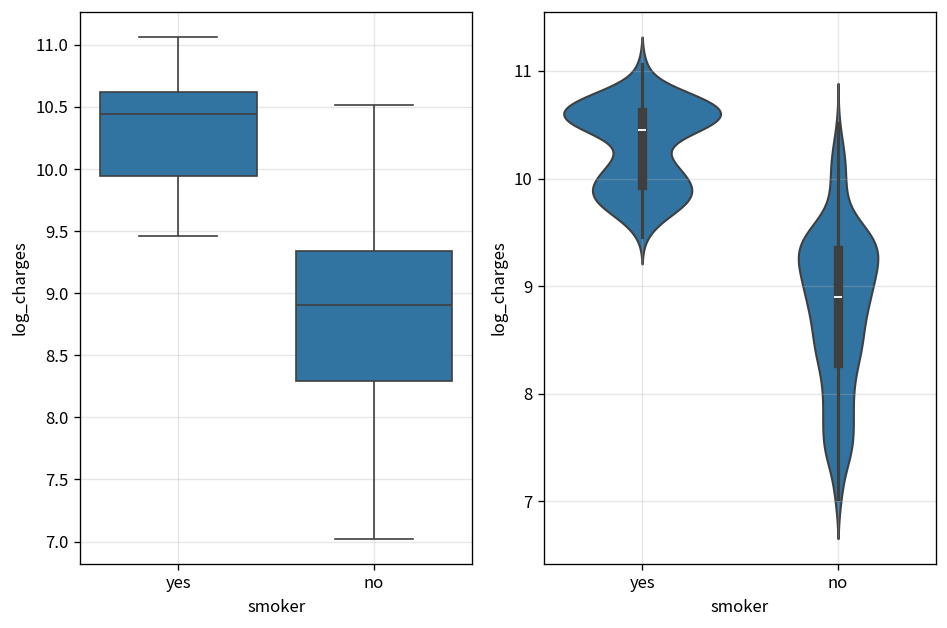

statistic:32.593, p-value:0.000, 대립 가설 채택


In [12]:
# 미션5-1-1 Smoker 시각화
df5 = DataFrame()
df5["log_charges"] = df2["log_charges"]
df5["smoker"] = origin["smoker"]

width_px = 960
height_px = 640
rows = 1
cols = 2

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.boxplot(data=df5, x="smoker", y=y, ax=ax[0])
sb.violinplot(data=df5, x="smoker", y=y, ax=ax[1])

ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)

# 4. 출력
plt.tight_layout()
plt.show()
plt.close()

# 미션5-1-2 T-Test
smok_y = df5.loc[df5["smoker"] == "yes", "log_charges"].reset_index(drop=True)
smok_n = df5.loc[df5["smoker"] == "no", "log_charges"].reset_index(drop=True)

s, p = ttest_ind(smok_y, smok_n)
print(
    "statistic:{0:.3f}, p-value:{1:.3f}, {2} 가설 채택".format(
        s, p, "대립" if p <= 0.05 else "귀무"
    )
)

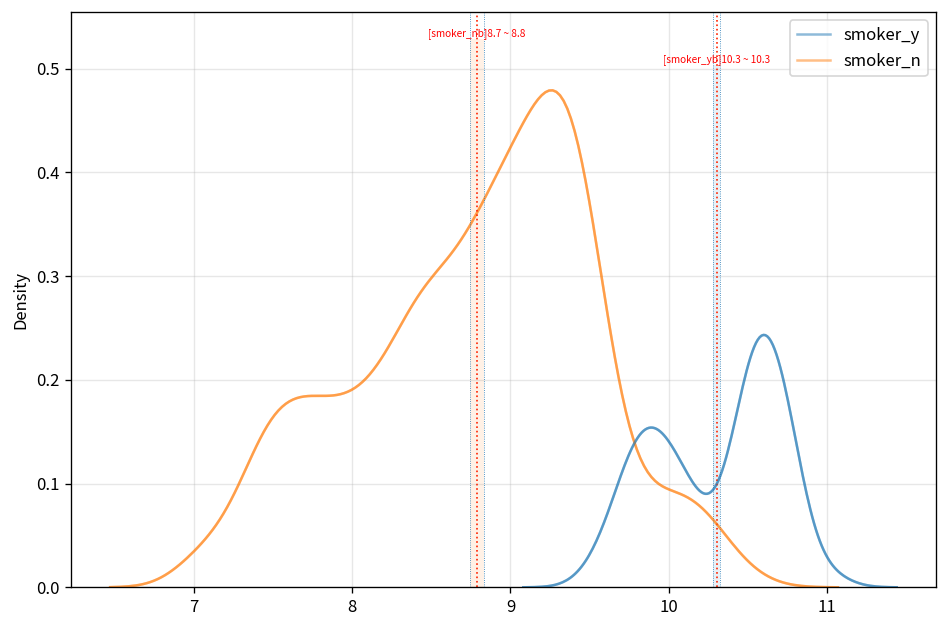

,statistic,p-value,result
field,,,
smoker_y,182.441412,2.417412e-40,False
smoker_n,37.435884,7.428501e-09,False
Levene,89.473006,1.347330e-20,False


,statistic,p-value,H0,H1,interpretation
alternative,,,,,
two-sided,284133.0,5.270233e-130,False,True,μ(smoker) != μ(non-smoker)
less,284133.0,1.000000e+00,True,False,μ(smoker) == μ(non-smoker)
greater,284133.0,2.635117e-130,False,True,μ(smoker) > μ(non-smoker)


 Mann–Whitney U 검정
 statistic: 284133.000, p-value: 2.635e-130, 대립가설 채택


In [13]:
# 미션5-3

# == 데이터분포 & 신뢰구간 == #
ttest_data = DataFrame({"smoker_y": smok_y, "smoker_n": smok_n})

data = ttest_data

width_px = 960
height_px = 640
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    sb.kdeplot(data=data, fill=False, alpha=0.5)
    max = data[c].max()
    clevel = 0.95
    dof = len(data[c]) - 1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=":", linewidth=0.5)
    ax.axvline(cmax, linestyle=":", linewidth=0.5)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    ax.axvline(sp_mean, linestyle=":", linewidth=1, color="#ff2200")

    ax.text(
        x=(cmax - cmin) / 2 + cmin,
        y=ymax,
        s="[%sb]%0.1f ~ %0.1f" % (c, cmin, cmax),
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"},
    )

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


# == 정규성 == #
equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    clean_data = data[c].dropna()
    equal_var_fields.append(clean_data)

    s, p = normaltest(clean_data)

    normalize = p > 0.05
    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

# == 등분산성 == #
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*equal_var_fields)
    else:
        n = "Levene"
        s, p = levene(*equal_var_fields, center="median")

    report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})

report_df = DataFrame(report).set_index("field")
display(report_df)


# == Mann–Whitney U == #
fields4 = ["smoker", "non-smoker"]
alternative = ["two-sided", "less", "greater"]
fmt = "μ({f0}) {0} μ({f1})"
input1 = ttest_data["smoker_y"].dropna()
input2 = ttest_data["smoker_n"].dropna()
result = []

result = []
for a in alternative:
    s, p = mannwhitneyu(input1, input2, alternative=a)
    ipt = None

    if a == "two-sided":
        itp = fmt.format("==" if p > 0.05 else "!=", f0=fields4[0], f1=fields4[1])
    elif a == "less":
        itp = fmt.format("==" if p > 0.05 else "<", f0=fields4[0], f1=fields4[1])
    else:
        itp = fmt.format("==" if p > 0.05 else ">", f0=fields4[0], f1=fields4[1])

    result.append(
        {
            "alternative": a,
            "statistic": s,
            "p-value": p,
            "H0": p > 0.05,
            "H1": p <= 0.05,
            "interpretation": itp,
        }
    )
    # 두 집단의 평균이 같다고 판정되면 이후 less, greater는 무의미하므로 중단
    if a == "two-sided" and p > 0.05:
        break

rdf = DataFrame(result)
display(rdf.set_index("alternative", inplace=False))
print(
    " Mann–Whitney U 검정\n",
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택".format(
        s, p, "대립" if p <= 0.05 else "귀무"
    ),
)

#### 미션5. 흡연과 의료비의 관계
1. smoker(흡연 여부)에 따라 charges가 다른지 시각화하고, 두 집단 평균 차이를 가설검정(예: t-test)으로 확인한다.
    - 흡연자/비흡연자의 log_charges 분포를 KDE plot으로 시각화함
    - 데이터가 정규성을 띠지 않아 로그 변환을 수행하였으나, 가설검정 결과 여전히 정규분포를 따르지 않았고, Levene 검정을 통해 등분산성 또한 위배됨을 확인하였음.
    
2. 효과 크기(차이의 크기)를 함께 제시하고, “실제로 의미 있는 차이인가?”를 말로 해석하세요.
    - 이미지의 KDE plot에서 흡연자의 곡선 피크가 비흡연자의 피크와 완전히 분리되어 훨씬 오른쪽에 위치한 것을 통해 시각적으로 큰 차이를 확인할 수 있음

3. 정규성/등분산 가정 점검 후 필요 시 Welch’s t-test나 비모수 검정을 선택하세요.
    - 정규성과 등분산성이 충족되지 않아 Welch's t-test을 고려하였으나, 두 집단의 모수가 달라 Mann–Whitney U 검정을 수행함

4. 효과 크기를 의료 정책 관점에서 의미를 서술합니다.
    - 흡연이 개인의 의료비 지출뿐만 아니라, 국가 전체의 건강보험 재정에 큰 부담으로 작용함
    - 2018년 기준, 미국에서 흡연으로 인한 총 경제적 비용은 6,000억 달러(약 800조 원) 이상으로 추산되었으며, 이 중 2,400억 달러(약 320조 원) 이상이 의료비 지출로 확인되었음
    - 건강보험개혁법(ACA, Obamacare)에 따라, 대부분의 주(State)에서는 보험사가 흡연자에게 비흡연자보다 최대 50%까지 높은 보험료를 부과할 수 있도록 허용함


[np.int64(18), np.int64(22), np.int64(29), np.int64(36), np.int64(43), np.int64(50), np.int64(57), np.int64(64)]


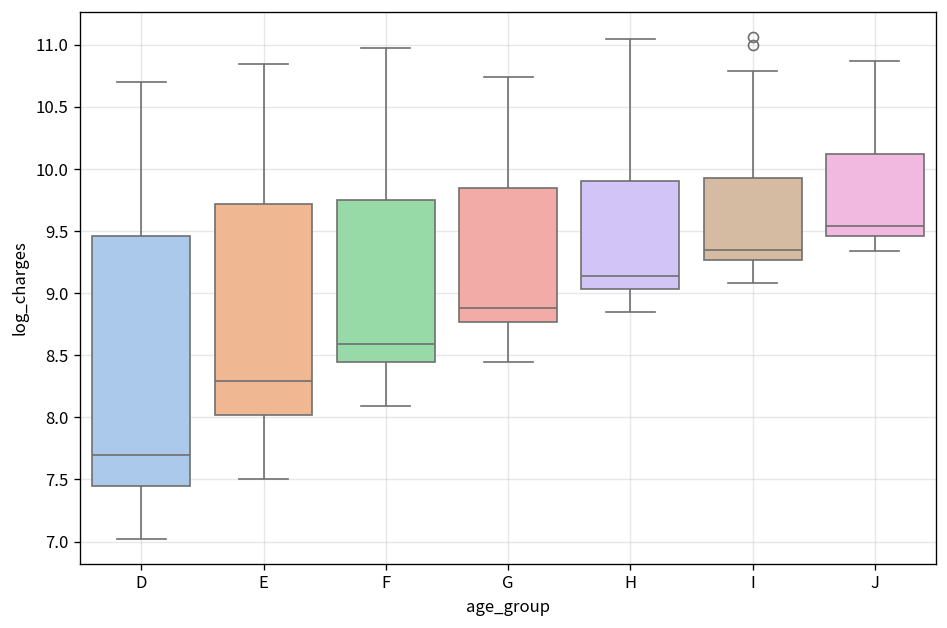

In [14]:
# 미션6-1
df6 = DataFrame()
df6["age"] = origin["age"]
df6["log_charges"] = df2["log_charges"]

# age 구간 설정
bins = jenkspy.jenks_breaks(df6["age"], n_classes=7)
print(bins)
df6["age_group"] = pd.cut(
    df6["age"],
    bins=bins,
    include_lowest=True,
    duplicates="drop",
    labels=["D", "E", "F", "G", "H", "I", "J"],
    # labels=["18-21", "22-28", "29-35", "36-42", "43-49", "50-56", "57-64"],
)

# 시각화
width_px = 960
height_px = 640
rows = 1
cols = 1

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.boxplot(
    data=df6,
    x="age_group",
    y="log_charges",
    orient="v",
    palette="pastel",
    hue="age_group",
)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [15]:
# 미션6-2
unique_label = df6["age_group"].unique()
group_data = [
    df6["log_charges"][df6["age_group"] == label].dropna() for label in unique_label
]
age_ranges_df = df6.groupby("age_group", observed=True)["age"].agg(["min", "max"])
display(age_ranges_df)

equal_var_fields = []
normal_dist = True
report = []

for i, c in enumerate(group_data):
    clean_data = c.dropna()
    equal_var_fields.append(clean_data)

    c = unique_label[i]

    s, p = normaltest(clean_data)

    normalize = p > 0.05
    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

# == 등분산성 == #
if len(equal_var_fields) > 1:
    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*equal_var_fields)
    else:
        n = "Levene"
        s, p = levene(*equal_var_fields, center="median")

    report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})

report_df = DataFrame(report).set_index("field")
display(report_df)

welch_anova_result = welch_anova(data=df6, dv="log_charges", between="age_group")
s = welch_anova_result["F"].iloc[0]
p = welch_anova_result["p-unc"].iloc[0]
print(
    "statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(
        s, p, "대립" if p <= 0.05 else "귀무"
    )
)
post_hoc = pairwise_gameshowell(data=df6, dv="log_charges", between="age_group")
display(post_hoc)

,min,max
age_group,,
D,18,22
E,23,29
F,30,36
G,37,43
H,44,50
I,51,57
J,58,64


,statistic,p-value,result
field,,,
D,35.873634,1.622330e-08,False
E,36.291336,1.316547e-08,False
F,28.632318,6.061375e-07,False
H,34.967966,2.551542e-08,False
G,28.957769,5.151104e-07,False
J,30.129840,2.866741e-07,False
I,44.175947,2.554554e-10,False
Levene,18.717339,5.402580e-21,False


statistic: 83.013, p-value: 0.000, 대립가설 채택


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,D,E,8.270248,8.709329,-0.439080,0.102768,-4.272555,413.854175,4.765407e-04,-0.413691
1,D,F,8.270248,8.966280,-0.696031,0.096205,-7.234904,389.839055,5.224343e-11,-0.696449
2,D,G,8.270248,9.217093,-0.946845,0.091138,-10.389176,364.340110,1.998401e-15,-0.986828
3,D,H,8.270248,9.416652,-1.146404,0.087227,-13.142818,336.113832,0.000000e+00,-1.240400
4,D,I,8.270248,9.568730,-1.298482,0.084791,-15.313991,310.862752,1.562084e-13,-1.433594
5,D,J,8.270248,9.760976,-1.490728,0.085200,-17.496858,311.989296,0.000000e+00,-1.615182
6,E,F,8.709329,8.966280,-0.256951,0.089519,-2.870345,368.921249,6.491032e-02,-0.293247
7,E,G,8.709329,9.217093,-0.507764,0.084050,-6.041210,347.302480,8.241260e-08,-0.613700
8,E,H,8.709329,9.416652,-0.707323,0.079792,-8.864538,320.274061,2.323697e-13,-0.895557
9,E,I,8.709329,9.568730,-0.859401,0.077122,-11.143411,293.308723,1.287859e-14,-1.125712


#### 미션6. 연령과 의료비의 관계
1. age를 여러 구간으로 나누어(예: 18~30, 31~50, 51+) 각 연령대별 charges 분포를 시각화한다.
    - 총 7개 구간으로 나누어 log_charges의 분포를 시각화함
    - 연령대가 높아질수록 의료비의 중앙값이 계단식으로 상승하는 경향이 보임

2. 분산분석(ANOVA)으로 전체 차이를 확인하고, 사후검정으로 어느 연령대 사이에서 차이가 나는지 정리한다.
    - 정규성, 등분산성이 모두 충족되지 않지만 표본수가 충분하여 Welch ANOVA를 수행행함
    - 그룹간 의료비 차이는 통계적으로 유의함

3. 사후검정은 Tukey HSD 또는 Games-Howell(등분산 위반 시)을 사용하고, “의료비 연령 서열표” 형태로 요약하세요.
    - 등분산성 위배로 인한 Games-Howell로 사후검정을 진행함

    |순위|그룹명|연령대|log_평균값 (추정 의료비 지출)|
    |---|---|---|---|
    |1|J|58-64|9.760976|
    |2|I|51-57|9.568730|
    |3|H|44-50|9.416652|
    |4|G|37-43|9.217093|
    |5|F|30-36|8.966280|
    |6|E|23-29|8.709329|
    |7|D|18-22|8.270248|


In [ ]:
df7 = 

NameError: name 'df7' is not defined

In [16]:
# 미션7
fields5 = ["age", "bmi", "children", "charges"]